In [1]:
import math
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

import sys

sys.path.append("../src/")
import utils
from NaCL import NaCLK

In [2]:
sys.setrecursionlimit(2000000)

In [3]:
X_train, y_train, X_test, y_test = utils.load_dataset("../data/splice", "splice")

In [4]:
X_train.shape

(2539, 240)

In [5]:
np.unique(y_train)

array([0, 1, 2])

In [6]:
%%time
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB().fit(X_train, y_train)
print(np.average(NB.predict(X_train) == y_train))
print(np.average(NB.predict(X_test) == y_test))

0.9614021268215833
0.9652996845425867
CPU times: user 144 ms, sys: 81.6 ms, total: 226 ms
Wall time: 45.5 ms


In [7]:
clf = LogisticRegression(solver='lbfgs',
    C = 0.1,
    verbose=True,
    multi_class='multinomial',
    max_iter=2000, n_jobs=6).fit(X_train, y_train)

np.average(clf.predict(X_test) == y_test), np.average(clf.predict(X_train) == y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    1.1s finished


(0.9652996845425867, 0.9810949192595511)

In [8]:
%%time
have_mosek = True # set False if you don't have mosek installed

nacl = NaCLK().setup(clf, X_train, y_train) # , c = 1e-10)
if have_mosek:
    nacl.solve(solver = 'mosek_conif', verbose=1) 
else:
    nacl.solve(solver = 'cvxopt', verbose=1) 

Using solver 'mosek_conif'
 for 1443 free variables
  in 1686 posynomial inequalities.
Solving took 0.167 seconds.
CPU times: user 4.39 s, sys: 652 ms, total: 5.04 s
Wall time: 3.98 s


In [9]:
%%time
print( np.average(np.mean(nacl.predict(X_test) == y_test)), np.average(clf.predict(X_test) == y_test) )
print( np.average(np.mean(nacl.predict(X_train) == y_train)), np.average(clf.predict(X_train) == y_train) )

0.9652996845425867 0.9652996845425867
0.9810949192595511 0.9810949192595511
CPU times: user 631 ms, sys: 460 ms, total: 1.09 s
Wall time: 103 ms


In [10]:
np.mean(nacl.predict(X_test) == clf.predict(X_test))

1.0

# Missing Data Experiments

In [11]:
X_test.shape

(634, 240)

In [12]:
%%time
setting = {
    "repeat": 5, #100
    "k": [i for i in range(0, 60, 6)],
    "prob" : True,
    "function": utils.conditional_likelihood_k,
    "discreteFeatures": 4
}
data_a2 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function conditional_likelihood_k at 0x7f61d77d4400>
Possible features to remove: 60
K = 0
	 R = 0
K = 6
	 R = 0
K = 12
	 R = 0
K = 18
	 R = 0
K = 24
	 R = 0
K = 30
	 R = 0
K = 36
	 R = 0
K = 42
	 R = 0
K = 48
	 R = 0
K = 54
	 R = 0
CPU times: user 41.3 s, sys: 32.2 s, total: 1min 13s
Wall time: 9.49 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

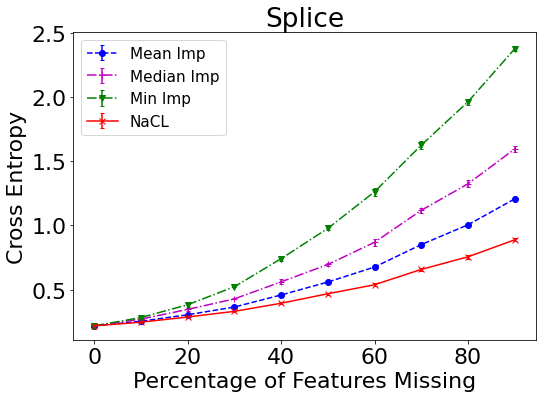

In [13]:
setting = {
    "show": ["min", "mean", "median", "ours"],
    "saveAs": "splice_cross.eps",
    "title": "Splice",
    "Ylabel": "Cross Entropy"
}
utils.plot_results_paper(data_a2, setting)

In [14]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "weighted")

setting = {
    "repeat": 10, # 100
    "k": [i for i in range(0, 240, 10)],
    "prob" : False,
    "function": f1,
    "discreteFeatures": 4
}
data_a3 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function <lambda> at 0x7f61c4fbdbf8>
Possible features to remove: 60
K = 0
	 R = 0
K = 10
	 R = 0
K = 20
	 R = 0
K = 30
	 R = 0
K = 40
	 R = 0
K = 50
	 R = 0
K = 60
	 R = 0
K = 70
Early stop: Only had 60 features possible to remove
CPU times: user 1min 13s, sys: 57.1 s, total: 2min 11s
Wall time: 17.1 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

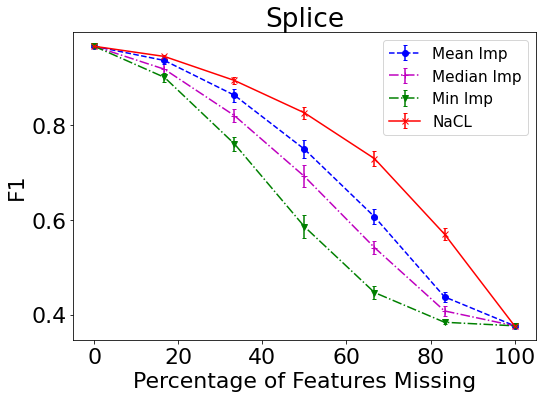

In [19]:
setting = {
    "show": ["min", "ours", "mean", "median"],
    "saveAs": "splice_accuracy.eps",
    "title": "Splice",
    "Ylabel": "F1"
}
utils.plot_results_paper(data_a3, setting)

In [16]:
utils.save("../results/data_splice_result_cross.pickle", data_a2)
utils.save("../results/data_splice_result_accuracy.pickle", data_a3)

# Table

In [17]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "weighted")

N = X_train.shape[1]
setting = {
    "repeat": 10, # choose 100 for better uncertatiny estimate
    "k": [i for i in range(0, N+1, int(0.2/4*N))],
    "prob" : False,
    "function": f1, #utils.conditional_likelihood_k,
    "discreteFeatures": 4
}
data_for_table = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function <lambda> at 0x7f61c4fbdb70>
Possible features to remove: 60
K = 0
	 R = 0
K = 12
	 R = 0
K = 24
	 R = 0
K = 36
	 R = 0
K = 48
	 R = 0
K = 60
	 R = 0
K = 72
Early stop: Only had 60 features possible to remove
CPU times: user 1min, sys: 47.1 s, total: 1min 47s
Wall time: 14 s


In [18]:
row = []
for method in ["min", "max", "mean", "median", "ours"]:
    temp = []
    for k in range(1, 5):
        m = np.mean(100*data_for_table[method][k])
        s = np.std(100*data_for_table[method][k])
        temp.append(np.round(m, 1))
        print(method, k*20, m, s)
        
    row.append(temp)

row = np.array(row)  
bold = np.argmax(row, axis=0)
print("")
for i in range(len(row)):
    line = ""
    for j in range(len(row[i])):
        if bold[j] == i or row[i][j] == row[bold[j]][j]:
            line += "\\textbf{" + str(row[i][j]) + "}"
        else:
            line += str(row[i][j])
        
        line += " & "
    print(line)
    

min 20 86.73275744900474 0.9215197805792467
min 40 69.35749569571198 1.7129633605472274
min 60 49.45160702694792 1.7822062254449607
min 80 38.99408063637195 0.6422326998013541
max 20 86.73275744900474 0.9215197805792467
max 40 69.3157094504917 1.763116900362636
max 60 49.45160702694792 1.7822062254449607
max 80 38.99408063637195 0.6422326998013541
mean 20 91.93172561349954 1.143447250432057
mean 40 82.43818413085847 1.1391097949317406
mean 60 66.21105782530694 1.7528283601113603
mean 80 46.97887384836148 1.377572511585308
median 20 89.2335561823393 0.9358740664560278
median 40 77.18704849265946 1.77596428526924
median 60 59.851549714438 1.339737249336804
median 80 42.855595190506705 0.977982987287173
ours 20 93.23202760719691 0.8468949929392864
ours 40 87.39201166569237 0.8971533728424732
ours 60 77.36548611121256 1.3919646181425702
ours 80 60.697836614922075 1.9049665494086334

86.7 & 69.4 & 49.5 & 39.0 & 
86.7 & 69.3 & 49.5 & 39.0 & 
91.9 & 82.4 & 66.2 & 47.0 & 
89.2 & 77.2 & 59.9 & 